In [2]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.nn.functional import softmax
from torch.nn import Sequential


class attn_layer(nn.Module):
    def __init__(self, d, a, normalize=True):
        super(attn_layer, self).__init__()

        self.Q = Parameter(torch.randn((1, 1, a, d), requires_grad=True))
        self.K = Parameter(torch.randn((1, 1, a, d), requires_grad=True))
        self.V = Parameter(torch.randn((1, 1, d, d), requires_grad=True))
        self.normalize = normalize

    def forward(self, x):
        Qx = (self.Q @ x.unsqueeze(-1)).squeeze(-1)
        Kx = (self.K @ x.unsqueeze(-1)).squeeze(-1)
        Vx = (self.V @ x.unsqueeze(-1)).squeeze(-1)
        A = (Qx.unsqueeze(1) * Kx.unsqueeze(2)).sum(-1)
        if self.normalize:
            A = softmax(A, 1)

        res = (A.unsqueeze(-1) * Vx.unsqueeze(2)).sum(1)
        return res


class deep_attn(nn.Module):
    def __init__(self, l, d, a, normalize=True):
        super(deep_attn, self).__init__()
        self.net = Sequential()
        for i in range(l):
            self.net.append(attn_layer(d, a, normalize=normalize))

    def forward(self, x):
        return self.net(x)



In [11]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.linalg import matrix_rank

t = 3

num_layers = 2

normalize = True

dim_vec = []

d_list = list(range(3, 11))
d_vec = np.array(d_list)

l_vec = np.array([num_layers] * len(d_list))
a_vec = np.array([2] * len(d_list))

sample_sizes =  [25, 40, 65, 85, 110, 140, 175, 250]

n_iter_array = [5, 5, 5, 5, 5, 5, 5, 8]

print(sample_sizes)

for l, a, d, n_samples, n_iters in zip(l_vec, a_vec, d_vec, sample_sizes, n_iter_array):
    print('Hidden dimension: ', a)
    print('Number of layers: ', l)
    print('Embedding dimension: ', d)
    print('Number of samples', n_samples)
    ranks = []
    for i in range(n_iters):
        grads = []
        model = deep_attn(l, d, a, normalize=normalize)
        x =  torch.randn(int(n_samples), t, d)
        y = model(x).flatten()
        for j in range(len(y)):
            model.zero_grad()
            y[j].backward(retain_graph=True)
            gr = torch.cat([p.grad.flatten() for p in model.parameters()])
            grads.append(gr.unsqueeze(0))
        jacob = torch.cat(grads, dim=0)
        ranks.append(matrix_rank(jacob))
    dim_vec.append(max(ranks))


[25, 40, 65, 85, 110, 140, 175, 250]
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  3
Number of samples 25
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  4
Number of samples 40
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  5
Number of samples 65
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  6
Number of samples 85
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  7
Number of samples 110
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  8
Number of samples 140
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  9
Number of samples 175
Hidden dimension:  2
Number of layers:  2
Embedding dimension:  10
Number of samples 250


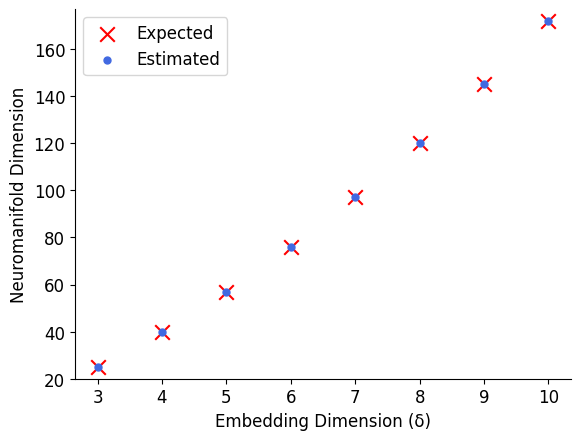

In [12]:
plt.figure()
plt.rcParams.update({'font.size': 12})
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

true_dim_vec = l_vec * (a_vec * (2 * d_vec - a_vec) ) + (d_vec * d_vec) - l_vec * (1 - int(normalize))

plt.scatter(d_vec, true_dim_vec, label='Expected', c='red', marker='x', s=110)
plt.scatter(d_vec, dim_vec, label='Estimated', c='royalblue', marker='o', s=25)

plt.xticks(d_vec)

plt.gca().set_ylim(true_dim_vec[0] - 5 , true_dim_vec[-1] + 5)
plt.xlabel('Embedding Dimension (δ)')
plt.ylabel('Neuromanifold Dimension')
plt.legend()

plt.savefig('./dimexp_delta.pdf')